<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/Prompt_engineering/Microsoft_Phi3_128k_prompt_Engineering_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.3.1 --progress-bar off
!pip install -qqq transformers==4.41.0 --progress-bar off
!pip install -qqq accelerate==0.31.0 --progress-bar off
!pip install -qqq flash_attn==2.5.8 --progress-bar off


  Preparing metadata (setup.py) ... done


# Phi-3 open models

https://huggingface.co/microsoft/Phi-3-mini-128k-instruct

https://arxiv.org/abs/2404.14219

https://azure.microsoft.com/en-us/products/phi-3

https://www.promptingguide.ai/

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

torch.random.manual_seed(0)

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-128k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-128k-instruct")


config.json:   0%|          | 0.00/3.48k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
# Disable tokenizers warnings when constructing pipelines
%env TOKENIZERS_PARALLELISM=false

import warnings

# Disable a few less-than-useful UserWarnings from setuptools and pydantic
warnings.filterwarnings("ignore", category=UserWarning)

env: TOKENIZERS_PARALLELISM=false


In [4]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [6]:
messages = [
    {"role": "system", "content": "Your are a clever assistant which helps to develop code , or answer math and logic questions developer."},
    {"role": "user", "content": "Help me generate a bubble algorithm"},
]

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 600,
    "return_full_text": False,
    "temperature": 0.3,
    "do_sample": True,
}

output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

 Certainly! The Bubble Sort algorithm is a simple sorting algorithm that repeatedly steps through the list, compares adjacent elements, and swaps them if they are in the wrong order. The pass through the list is repeated until the list is sorted. Here's a simple implementation in Python:

```python
def bubble_sort(arr):
    n = len(arr)

    # Traverse through all array elements
    for i in range(n):

        # Last i elements are already in place
        for j in range(0, n-i-1):

            # Traverse the array from 0 to n-i-1
            # Swap if the element found is greater than the next element
            if arr[j] > arr[j+1]:
                arr[j], arr[j+1] = arr[j+1], arr[j]

# Example usage
arr = [64, 34, 25, 12, 22, 11, 90]
bubble_sort(arr)
print("Sorted array is:", arr)
```

Output:
```
Sorted array is: [11, 12, 22, 25, 34, 64, 90]
```

This implementation of Bubble Sort has a time complexity of O(n^2) in the worst and average cases, making it inefficient on large lists.

# Zero-Shot Prompting
Large LLMs today, such as GPT-3, Mistral or Llama 2 are tuned to follow instructions and are trained on large amounts of data; so they are capable of performing some tasks "zero-shot."

In [37]:

text = """Classify the text into neutral, negative or positive.
Text: I think the vacation is okay.
Sentiment:?  """

In [38]:
messages = [
    {"role": "system", "content": "Your are a clever assistant which can helps answering general questions and also math and logic questions."},
    {"role": "user", "content": text},
]



output = pipe(messages, **generation_args)
pprint.pprint(output[0]['generated_text'])

(' Sentiment: Neutral\n'
 '\n'
 'The text "I think the vacation is okay" expresses a moderate or average '
 'opinion about the vacation, without indicating a particularly positive or '
 'negative sentiment. Therefore, the sentiment can be classified as neutral.')


# Few-Shot Prompting
While large-language models demonstrate remarkable zero-shot capabilities, they still fall short on more complex tasks when using the zero-shot setting. Few-shot prompting can be used as a technique to enable in-context learning where we provide demonstrations in the prompt to steer the model to better performance. The demonstrations serve as conditioning for subsequent examples where we would like the model to generate a response.

In [39]:

text = """ Context :"whatpu" is a small, furry animal native to Tanzania.
An example of a sentence that uses the word whatpu is: We were traveling in Africa and we saw these very cute whatpus.

Question:
To do a "farduddle" means to jump up and down really fast.
can you give me an example that uses the word farduddle :? """

In [40]:
messages = [
    {"role": "system", "content": "Your are a clever assistant which can helps answering general questions and also math and logic questions."},
    {"role": "user", "content": text},
]



output = pipe(messages, **generation_args)
pprint.pprint(output[0]['generated_text'])

(' Certainly! Here\'s an example sentence using the word "farduddle":\n'
 '\n'
 'After watching the energetic children at the village playground, we decided '
 'to join in and farduddle with them for a while.')


# Chain-of-Thought Prompting

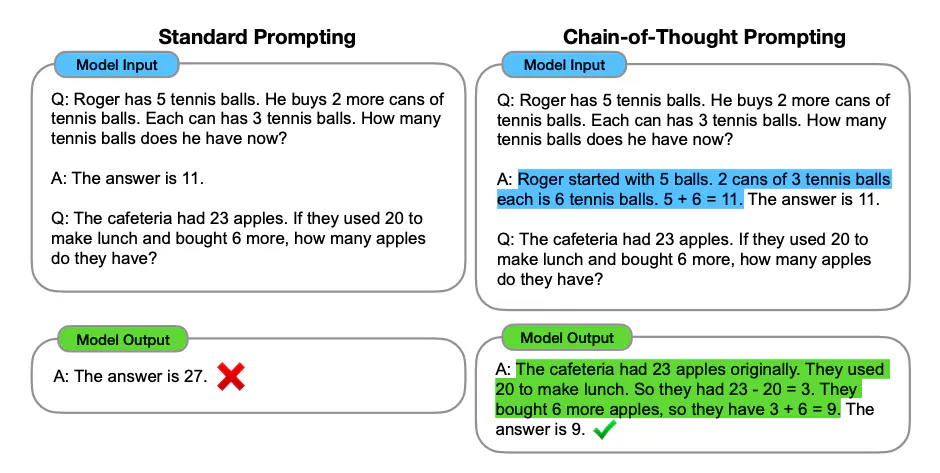

# Chain-of-Thought Prompting Elicits Reasoning in Large Language Models

Introduced in Wei et al. (2022), chain-of-thought (CoT) prompting enables complex reasoning capabilities through intermediate reasoning steps. You can combine it with few-shot prompting to get better results on more complex tasks that require reasoning before responding.

Chain-of-Thought Prompting Elicits Reasoning in Large Language Models

https://arxiv.org/abs/2201.11903

In [41]:
text = """

Question : The odd numbers in this group add up to an even number: Group = (4, 8, 9, 15, 12, 2, 1).
Answer : Adding all the odd numbers (9, 15, 1) gives 25. The answer is False.

Question :  The odd numbers in this group add up to an even number: Group = (15, 32, 5, 13, 82, 7, 1).
Answer :?

"""

In [42]:
messages = [
    {"role": "system", "content": "Your are a clever assistant which can helps answering general questions and also math and logic questions."},
    {"role": "user", "content": text},
]



output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

 Adding all the odd numbers (15, 5, 13, 7, 1) gives 41. The answer is False.


# Zero-shot COT Prompting --> chain of thought

# https://arxiv.org/pdf/2205.11916.pdf

One recent idea that came out more recently is the idea of zero-shot CoT (Kojima et al. 2022) that essentially involves adding "Let's think step by step" to the original prompt. Let's try a simple problem and see how the model performs:

A man has 53 socks in his drawer: 21 identical blue, 15 identical black and 17 identical red. The lights are out and he is completely in the dark. How many socks must he take out to make 100 percent certain he has at least one pair of black socks?

Answer: 40 socks. If he takes out 38 socks (adding the two biggest amounts, 21 and 17), although it is very unlikely, it is possible they could all be blue and red. To make 100 percent certain that he also has a pair of black socks he must take out a further two socks.

In [43]:
text = """
A man has 53 socks in his drawer: 21 identical blue, 15 identical black and 17 identical red. The lights are out and he is completely in the dark.
How many socks must he take out to make 100 percent certain he has at least one pair of black socks?

"""

In [47]:
text = """The day before two days after the day before tomorrow is Saturday. What day is it today?"""

#The “day before tomorrow” is today; “the day before two days after” is really one day after. So if “one day after today is Saturday,” then it must be Friday.

In [48]:
messages = [
    {"role": "system", "content": "Your are a clever assistant which can helps answering general questions and also math and logic questions."},
    {"role": "user", "content": text},
]

output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

 Let's break down the statement step by step:

1. "Two days after tomorrow" would be two days after the day after today.
2. "The day before that" would be one day before the day after tomorrow.
3. So, the statement says that "the day before two days after the day before tomorrow" is Saturday.

Let's call today "Day 0". Then, two days after tomorrow would be "Day 3". The day before that would be "Day 2". So, the statement is saying that "Day 2" is Saturday.

If Day 2 is Saturday, then today (Day 0) would be Thursday.


In [45]:
text = """
A man has 53 socks in his drawer: 21 identical blue, 15 identical black and 17 identical red. The lights are out and he is completely in the dark.
How many socks must he take out to make 100 percent certain he has at least one pair of black socks?
Let's think step by step.
"""

In [51]:
text = """The day before two days after the day before tomorrow is Saturday. What day is it today?
Let's think step by step."""

In [52]:
messages = [
    {"role": "system", "content": "Your are a clever assistant which can helps answering general questions and also math and logic questions."},
    {"role": "user", "content": text},
]

output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

 Let's break down the statement step by step:

1. "Two days after the day before tomorrow" means we need to find the day that is two days after the day before the day after today.
2. "The day before that" means we need to find the day that is one day before the day we found in step 1.
3. According to the statement, this day is Saturday.

Now let's work backward:

1. If the day two days after the day before tomorrow is Saturday, then the day before that is Friday.
2. If the day before that (Friday) is two days after the day before tomorrow, then the day before tomorrow is Wednesday.
3. If the day before tomorrow is Wednesday, then today is Monday.

So, today is Monday.


# Self-Consistency
# Self-Consistency Improves Chain of Thought Reasoning in Language Models --> https://arxiv.org/abs/2203.11171

Chain-of-thought prompting combined with pre-trained large language models has achieved encouraging results on complex reasoning tasks. In this paper, we propose a new decoding strategy, self-consistency, to replace the naive greedy decoding used in chain-of-thought prompting. It first samples a diverse set of reasoning paths instead of only taking the greedy one, and then selects the most consistent answer by marginalizing out the sampled reasoning paths. Self-consistency leverages the intuition that a complex reasoning problem typically admits multiple different ways of thinking leading to its unique correct answer. Our extensive empirical evaluation shows that self-consistency boosts the performance of chain-of-thought prompting with a striking margin on a range of popular arithmetic and commonsense reasoning benchmarks, including GSM8K (+17.9%), SVAMP (+11.0%), AQuA (+12.2%), StrategyQA (+6.4%) and ARC-challenge (+3.9%).

Perhaps one of the more advanced techniques out there for prompt engineering is self-consistency. Proposed by Wang et al. (2022), self-consistency aims "to replace the naive greedy decoding used in chain-of-thought prompting". The idea is to sample multiple, diverse reasoning paths through few-shot CoT, and use the generations to select the most consistent answer. This helps to boost the performance of CoT prompting on tasks involving arithmetic and commonsense reasoning.

In [53]:
text = """
Question: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done,
there will be 21 trees. How many trees did the grove workers plant today?
Answer: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted.
So, they must have planted 21 - 15 = 6 trees. The answer is 6.

Question: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
Answer: There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.

Question: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
Answer: Leah had 32 chocolates and Leah’s sister had 42. That means there were originally 32 + 42 = 74
chocolates. 35 have been eaten. So in total they still have 74 - 35 = 39 chocolates. The answer is 39.

Question: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops
did Jason give to Denny?
Answer: Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of
lollipops he has given to Denny must have been 20 - 12 = 8 lollipops. The answer is 8.

Question: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does
he have now?
Answer: He has 5 toys. He got 2 from mom, so after that he has 5 + 2 = 7 toys. Then he got 2 more from dad, so
in total he has 7 + 2 = 9 toys. The answer is 9.

Question: There were nine computers in the server room. Five more computers were installed each day, from
monday to thursday. How many computers are now in the server room?
Answer: There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 =
20 computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers.
The answer is 29.

Question: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many
golf balls did he have at the end of wednesday?
Answer: Michael initially had 58 balls. He lost 23 on Tuesday, so after that he has 58 - 23 = 35 balls. On
Wednesday he lost 2 more so now he has 35 - 2 = 33 balls. The answer is 33.

Question: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
Answer: She bought 5 bagels for $3 each. This means she spent $15. She has $8 left.


Question : When I was 6 my sister was half my age. Now I’m 70 years old.
Answer : how old is my sister now?

 """

In [54]:
messages = [
    {"role": "system", "content": "Your are a clever assistant which can helps answering general questions and also math and logic questions."},
    {"role": "user", "content": text},
]

output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

 When you were 6, your sister was half your age, which means she was 6/2 = 3 years old. The age difference between you and your sister is 6 - 3 = 3 years. Now that you're 70 years old, your sister must be 70 - 3 = 67 years old. The answer is 67.


# Generated Knowledge Prompting
## Generated Knowledge Prompting for Commonsense Reasoning https://arxiv.org/pdf/2110.08387.pdf
LLMs continue to be improved and one popular technique includes the ability to incorporate knowledge or information to help the model make more accurate predictions.

Using a similar idea, can the model also be used to generate knowledge before making a prediction? That's what is attempted in the paper by Liu et al. 2022 -- generate knowledge to be used as part of the prompt.

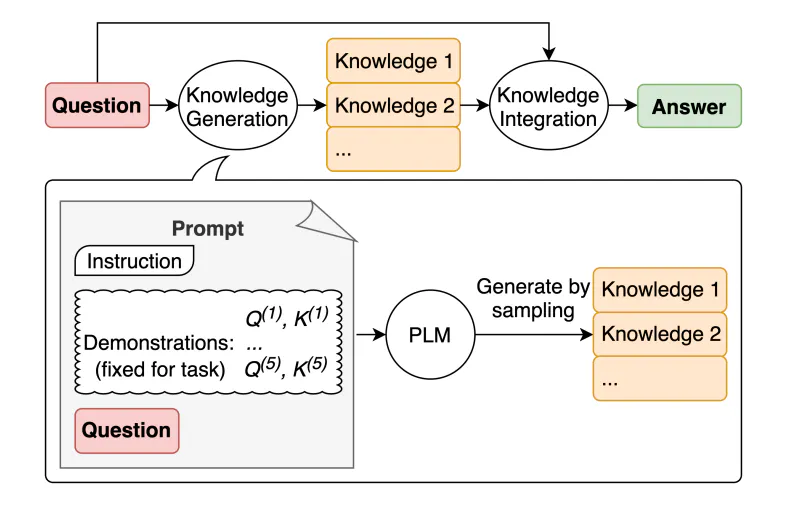

In [55]:
text = """
Input: Greece is larger than mexico.
Knowledge: Greece is approximately 131,957 sq km, while Mexico is approximately 1,964,375 sq km, making Mexico 1,389% larger than Greece.

Input: Glasses always fog up.
Knowledge: Condensation occurs on eyeglass lenses when water vapor from your sweat, breath, and ambient humidity lands on a cold surface, cools, and then changes into tiny drops of liquid, forming a film that you see as fog. Your lenses will be relatively cool compared to your breath, especially when the outside air is cold.

Input: A fish is capable of thinking.
Knowledge: Fish are more intelligent than they appear. In many areas, such as memory, their cognitive powers match or exceed those of ’higher’ vertebrates including non-human primates. Fish’s long-term memories help them keep track of complex social relationships.

Input: A common effect of smoking lots of cigarettes in one’s lifetime is a higher than normal chance of getting lung cancer.
Knowledge: Those who consistently averaged less than one cigarette per day over their lifetime had nine times the risk of dying from lung cancer than never smokers. Among people who smoked between one and 10 cigarettes per day, the risk of dying from lung cancer was nearly 12 times higher than that of never smokers.

Input: A rock is the same size as a pebble.
Knowledge: A pebble is a clast of rock with a particle size of 4 to 64 millimetres based on the Udden-Wentworth scale of sedimentology. Pebbles are generally considered larger than granules (2 to 4 millimetres diameter) and smaller than cobbles (64 to 256 millimetres diameter).

Input: Part of golf is trying to get a higher point total than others.
Knowledge:
The objective of golf is to play a set of holes in the least number of strokes. A round of golf typically consists of 18 holes. Each hole is played once in the round on a standard golf course. Each stroke is counted as one point, and the total number of strokes is used to determine the winner of the game.

Question: Part of golf is trying to get a higher point total than others. Yes or No?
"""

In [56]:
messages = [
    {"role": "system", "content": "Your are a clever assistant which can helps answering general questions and also math and logic questions."},
    {"role": "user", "content": text},
]

output = pipe(messages, **generation_args)
pprint.pprint(output[0]['generated_text'])

(' Yes, part of golf is trying to get a higher point total than others. The '
 'objective of golf is to play a set of holes in the least number of strokes, '
 'and the total number of strokes is used to determine the winner.')


In [57]:
text = """
Input: Greece is larger than mexico.
Knowledge: Greece is approximately 131,957 sq km, while Mexico is approximately 1,964,375 sq km, making Mexico 1,389% larger than Greece.

Input: Glasses always fog up.
Knowledge: Condensation occurs on eyeglass lenses when water vapor from your sweat, breath, and ambient humidity lands on a cold surface, cools, and then changes into tiny drops of liquid, forming a film that you see as fog. Your lenses will be relatively cool compared to your breath, especially when the outside air is cold.

Input: A fish is capable of thinking.
Knowledge: Fish are more intelligent than they appear. In many areas, such as memory, their cognitive powers match or exceed those of ’higher’ vertebrates including non-human primates. Fish’s long-term memories help them keep track of complex social relationships.

Input: A common effect of smoking lots of cigarettes in one’s lifetime is a higher than normal chance of getting lung cancer.
Knowledge: Those who consistently averaged less than one cigarette per day over their lifetime had nine times the risk of dying from lung cancer than never smokers. Among people who smoked between one and 10 cigarettes per day, the risk of dying from lung cancer was nearly 12 times higher than that of never smokers.

Input: A rock is the same size as a pebble.
Knowledge: A pebble is a clast of rock with a particle size of 4 to 64 millimetres based on the Udden-Wentworth scale of sedimentology. Pebbles are generally considered larger than granules (2 to 4 millimetres diameter) and smaller than cobbles (64 to 256 millimetres diameter).

Input: Part of golf is trying to get a higher point total than others.
Knowledge:
Golf is a precision club-and-ball sport in which competing players (or golfers) use many types of clubs to hit balls into a series of holes on a course using the fewest number of strokes. The goal is to complete the course with the lowest score, which is calculated by adding up the total number of strokes taken on each hole. The player with the lowest score wins the game.

Question: Part of golf is trying to get a higher point total than others. Yes or No?
"""



In [58]:
messages = [
    {"role": "system", "content": "Your are a clever assistant which can helps answering general questions and also math and logic questions."},
    {"role": "user", "content": text},
]

output = pipe(messages, **generation_args)
pprint.pprint(output[0]['generated_text'])

(' No, the goal in golf is to complete the course with the lowest score, not a '
 'higher point total than others.')


# Prompt Chaining
To improve the reliability and performance of LLMs, one of the important prompting engineering techniques is to break tasks into its subtasks. Once those subtasks have been identified, the LLM is prompted with a subtask and then its response is used as input to another prompt. This is what's referred to as prompt chaining where a task is split into subtasks with the idea to create a chain of prompt operations.

Prompt chaining is useful to accomplish complex which an LLM might struggle to address if prompted with a very detailed prompt. In prompt chaining, chain prompts perform transformations or additional processes on the generated responses before reaching a final desired state.

Besides achieving better performance, prompt chaining helps to boost transparency of your LLM application, increases controllability, and reliability. This means that you can debug problems with model responses much easier and analyze and improve performance in the different stages that need improvement.

Prompt chaining is particularly useful when building LLM-powered conversational assistants and improving the personalization and user experience of your applications.

In [59]:

with open("/content/drive/MyDrive/data/llm_doc.txt", "r",encoding='windows-1252') as f:
  document = f.read()

In [60]:
len(document)

119397

In [62]:
text = f"""
####
{document[:10000]}
####
"""

In [63]:
messages = [
    {"role": "system", "content": """You are a helpful assistant. Your task is to help answer a question given a document. The first step is to extract quotes relevant to the question from the document, delimited by ####. Please output the list of quotes using <quotes></quotes>. Respond with "No relevant quotes found!" if no relevant quotes were found."""},
    {"role": "user", "content": text},
]

output = pipe(messages, **generation_args)
pprint.pprint(output[0]['generated_text'])


(' <quotes>\n'
 '\n'
 '"We show that LLMs are decent zero-shot reasoners by simply adding “Let’s '
 'think step by step” before each answer."\n'
 '\n'
 '"Our Zero-shot-CoT successfully generates a plausible reasoning path in a '
 'zero-shot manner and reaches the correct answer in a problem where the '
 'standard zero-shot approach fails."\n'
 '\n'
 '"Importantly, our Zero-shot-CoT underperforms Few-shot-CoT with '
 'carefully-crafted and task-specific step-by-step ex- amples, Zero-shot-CoT '
 'achieves enormous score gains compared to the zero-shot baseline."\n'
 '\n'
 '"Importantly, with our single fixed prompt, zero-shot LLMs have a '
 'significantly better scaling curve comparable to that of the few-shot CoT '
 'baseline."\n'
 '\n'
 '"We hope our work not only serves as the minimal strongest zero-shot '
 'baseline for the challenging reasoning benchmarks, but also highlights the '
 'importance of carefully exploring and analyzing the enormous zero-shot '
 'knowledge hidden inside L

# Retrieval Augmented Generation (RAG)
General-purpose language models can be fine-tuned to achieve several common tasks such as sentiment analysis and named entity recognition. These tasks generally don't require additional background knowledge.

For more complex and knowledge-intensive tasks, it's possible to build a language model-based system that accesses external knowledge sources to complete tasks. This enables more factual consistency, improves reliability of the generated responses, and helps to mitigate the problem of "hallucination".

Meta AI researchers introduced a method called Retrieval Augmented Generation (RAG) to address such knowledge-intensive tasks. RAG combines an information retrieval component with a text generator model. RAG can be fine-tuned and its internal knowledge can be modified in an efficient manner and without needing retraining of the entire model.

RAG takes an input and retrieves a set of relevant/supporting documents given a source (e.g., Wikipedia). The documents are concatenated as context with the original input prompt and fed to the text generator which produces the final output. This makes RAG adaptive for situations where facts could evolve over time. This is very useful as LLMs's parametric knowledge is static. RAG allows language models to bypass retraining, enabling access to the latest information for generating reliable outputs via retrieval-based generation.

Lewis et al., (2021) proposed a general-purpose fine-tuning recipe for RAG. A pre-trained seq2seq model is used as the parametric memory and a dense vector index of Wikipedia is used as non-parametric memory (accessed using a neural pre-trained retriever). Below is a overview of how the approach works:

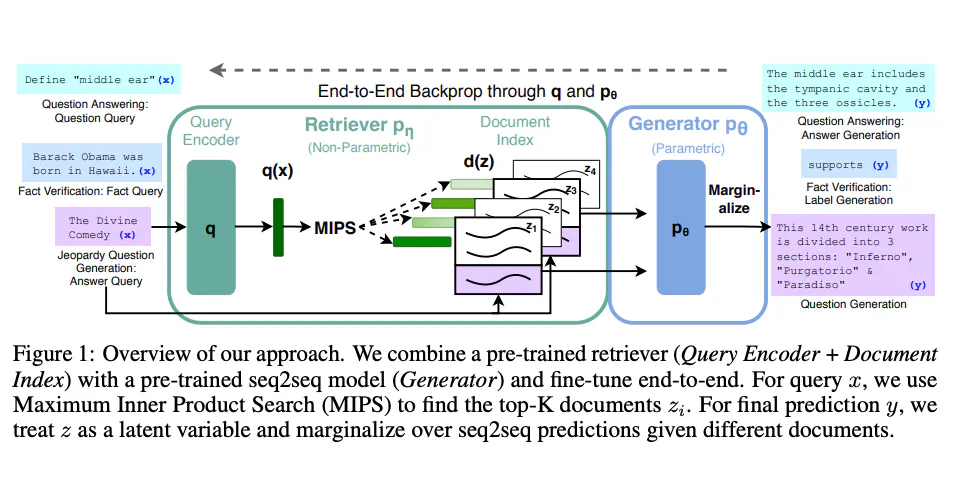

# Hallucinations

https://www.iguazio.com/glossary/llm-hallucination/

LLM hallucinations are the events in which ML models, particularly large language models (LLMs) like GPT-3 or GPT-4, produce outputs that are coherent and grammatically correct but factually incorrect or nonsensical. “Hallucinations” in this context means the generation of false or misleading information. These hallucinations can occur due to various factors, such as limitations in training data, biases in the model, or the inherent complexity of language.

In the example below you can see an amusing, albeit mostly harmless, example. However, LLM hallucinations are particularly concerning in fields that require high levels of accuracy and have a significant impact on people’s lives, like healthcare, law, or engineering.

Therefore, it’s essential to cross-reference the information provided by LLMs.

An LLM hallucination in action:

In [65]:
text = f"""
How many 'm's are in the word 'Weather'?
 """

In [66]:
messages = [
    {"role": "system", "content": "Your are a clever assistant which can helps answering general questions and also math and logic questions."},
    {"role": "user", "content": text},
]

output = pipe(messages, **generation_args)
pprint.pprint(output[0]['generated_text'])

" There is one'm' in the word 'Weather'."


In [67]:
text = f"""
quention: How many 'm's are in the word 'Weather'?
your previous answer: " There is 1'm' in the word 'Weather'."
question: Are you sure?
answer:?
 """

In [68]:
messages = [
    {"role": "system", "content": "Your are a clever assistant which can helps answering general questions and also math and logic questions."},
    {"role": "user", "content": text},
]

output = pipe(messages, **generation_args)
pprint.pprint(output[0]['generated_text'])

(" I apologize for any confusion. Upon reevaluating the word 'Weather,' I can "
 "confirm that there is indeed only one'm' present in the word. Thank you for "
 'your attention to detail.')


In [69]:
text = f"""
quention: How many 'm's are in the word 'Weather'?
your previous answer: " There is 1'm' in the word 'Weather'."
question: Are you sure?
your second answer:  "I apologize for any confusion. Upon reevaluating the word 'Weather,' I can confirm that there is indeed only one'm' present in the word. Thank you for your attention to detail."
question: Are you really sure?
answer:?
 """

In [70]:
messages = [
    {"role": "system", "content": "Your are a clever assistant which can helps answering general questions and also math and logic questions."},
    {"role": "user", "content": text},
]

output = pipe(messages, **generation_args)
pprint.pprint(output[0]['generated_text'])

(" I understand your need for certainty. To ensure accuracy, let's count "
 "the'm's in the word 'Weather' together. The word 'Weather' has the following "
 'letters: W-e-a-t-h-e-r. By examining each letter, we can see that there is '
 "only one'm' present. Therefore, I can confidently confirm that there is only "
 "one'm' in the word 'Weather'.")


In [71]:
text = f"""
quention: How was the winner of world cup 2024
answer:?
 """

In [72]:
messages = [
    {"role": "system", "content": "Your are a clever assistant which can helps answering general questions and also math and logic questions."},
    {"role": "user", "content": text},
]

output = pipe(messages, **generation_args)
pprint.pprint(output[0]['generated_text'])

(" I'm sorry, but as of my last update in April 2023, the World Cup 2024 has "
 'not yet taken place. Therefore, I cannot provide information on the winner '
 'of the event. The FIFA World Cup is held every four years, and the next one '
 'after 2022 will be in 2026. Please check back closer to the event for the '
 'latest updates and results.')


# Automatic Reasoning and Tool-use (ART)

Combining CoT prompting and tools in an interleaved manner has shown to be a strong and robust approach to address many tasks with LLMs. These approaches typically require hand-crafting task-specific demonstrations and carefully scripted interleaving of model generations with tool use. Paranjape et al., (2023) propose a new framework that uses a frozen LLM to automatically generate intermediate reasoning steps as a program.

ART works as follows:

given a new task, it select demonstrations of multi-step reasoning and tool use from a task library
at test time, it pauses generation whenever external tools are called, and integrate their output before resuming generation
ART encourages the model to generalize from demonstrations to decompose a new task and use tools in appropriate places, in a zero-shot fashion. In addition, ART is extensible as it also enables humans to fix mistakes in the reasoning steps or add new tools by simply updating the task and tool libraries. The process is demonstrated below:

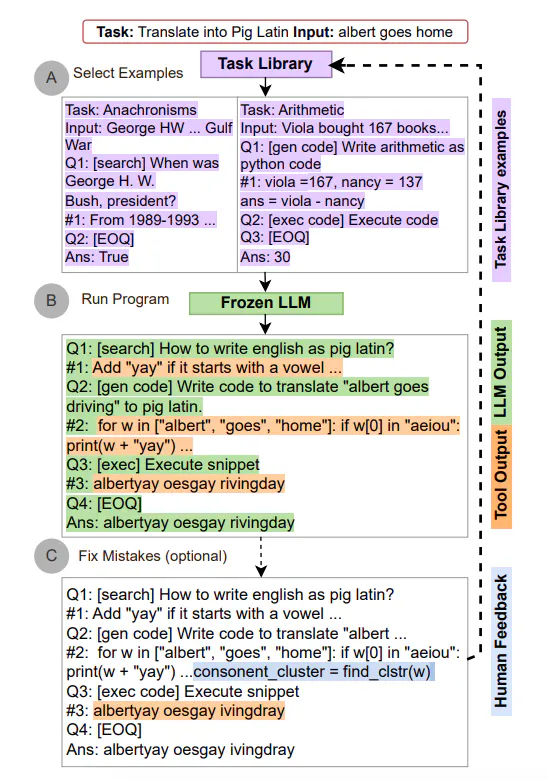

# Automatic Prompt Engineer (APE)

Zhou et al., (2022) propose automatic prompt engineer (APE) a framework for automatic instruction generation and selection. The instruction generation problem is framed as natural language synthesis addressed as a black-box optimization problem using LLMs to generate and search over candidate solutions.

The first step involves a large language model (as an inference model) that is given output demonstrations to generate instruction candidates for a task. These candidate solutions will guide the search procedure. The instructions are executed using a target model, and then the most appropriate instruction is selected based on computed evaluation scores.

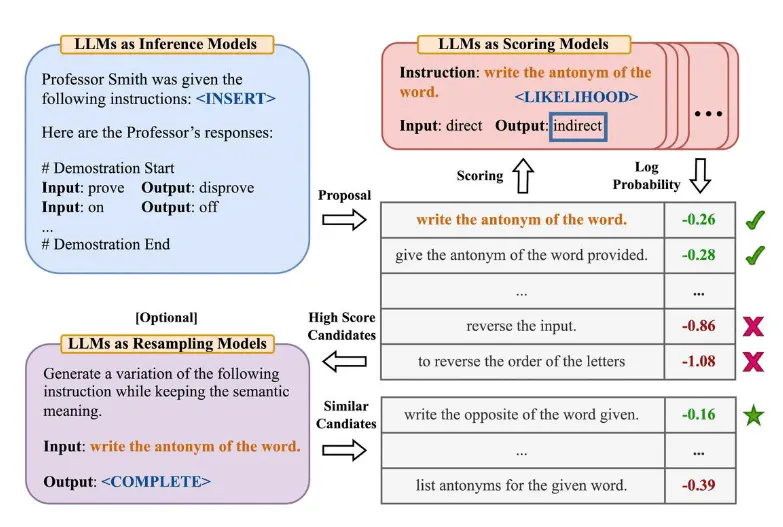

# Active-Prompt
Chain-of-thought (CoT) methods rely on a fixed set of human-annotated exemplars. The problem with this is that the exemplars might not be the most effective examples for the different tasks. To address this, Diao et al., (2023) recently proposed a new prompting approach called Active-Prompt to adapt LLMs to different task-specific example prompts (annotated with human-designed CoT reasoning).

Below is an illustration of the approach. The first step is to query the LLM with or without a few CoT examples. k possible answers are generated for a set of training questions. An uncertainty metric is calculated based on the k answers (disagreement used). The most uncertain questions are selected for annotation by humans. The new annotated exemplars are then used to infer each question.

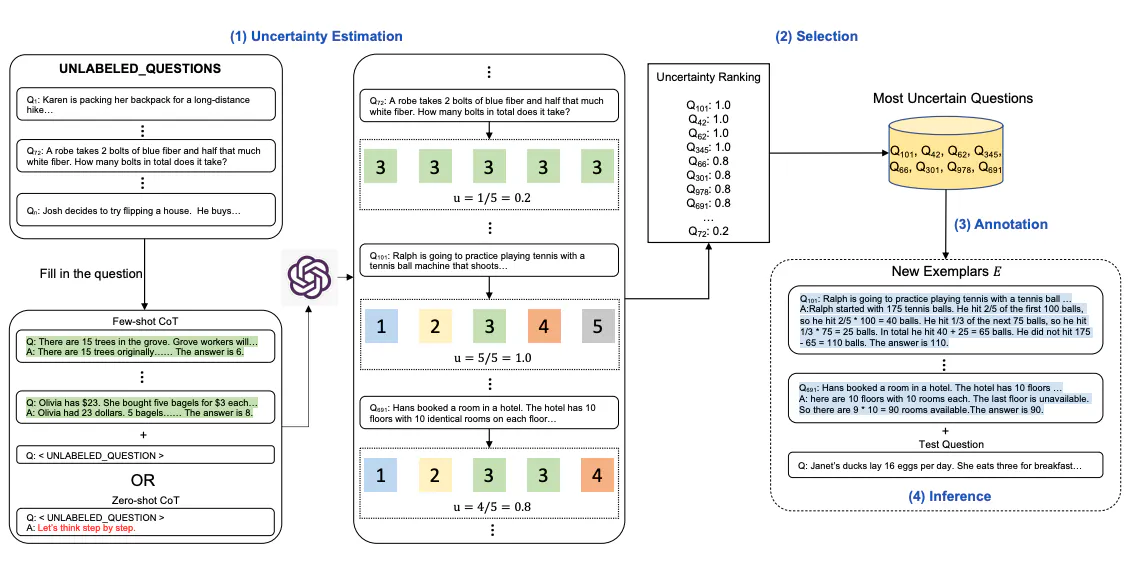

# Directional Stimulus Prompting

Li et al., (2023) proposes a new prompting technique to better guide the LLM in generating the desired summary.

A tuneable policy LM is trained to generate the stimulus/hint. Seeing more use of RL to optimize LLMs.

The figure below shows how Directional Stimulus Prompting compares with standard prompting. The policy LM can be small and optimized to generate the hints that guide a black-box frozen LLM.


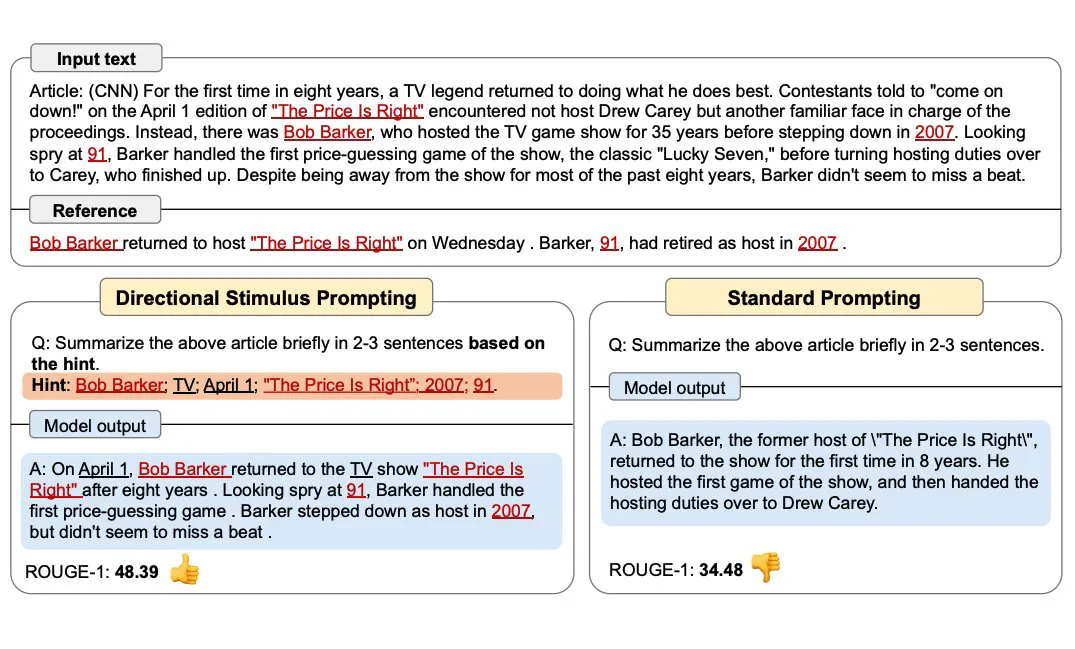


# PAL (Program-Aided Language Models)

Gao et al., (2022) presents a method that uses LLMs to read natural language problems and generate programs as the intermediate reasoning steps. Coined, program-aided language models (PAL), it differs from chain-of-thought prompting in that instead of using free-form text to obtain solution it offloads the solution step to a programmatic runtime such as a Python interpreter.

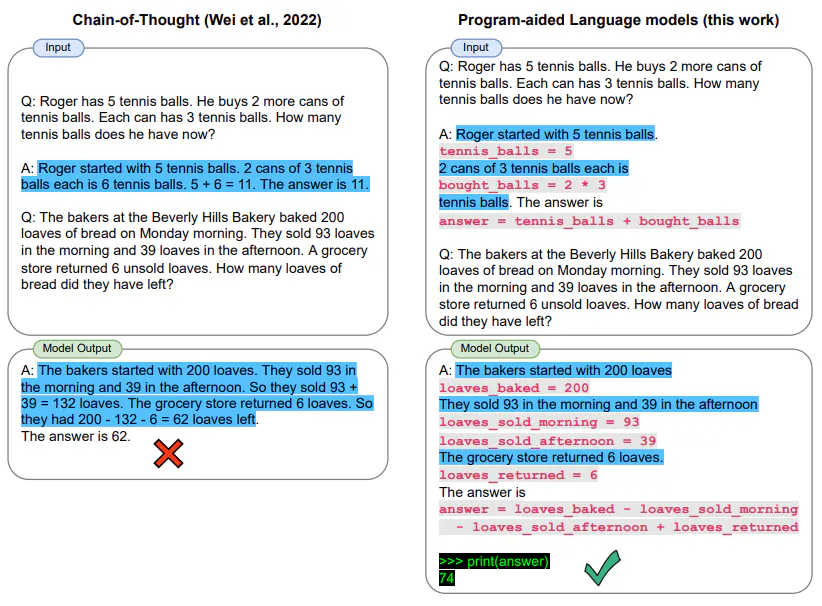


Other Prompting Techniques

- ReAct Prompting https://www.promptingguide.ai/techniques/react
- Multimodal CoT Prompting https://www.promptingguide.ai/techniques/multimodalcot
- GraphPrompts https://www.promptingguide.ai/techniques/graph